In [1]:
# !pip install datasets
# !pip install huggingface_hub
# !pip install tfds-nightly
# !pip install --upgrade tfds-nightly
# !pip install opencv-contrib-python

In [1]:
# OS
import io
import os
import glob
import shutil
import random

# 데이터셋 불러오고 확인용
import datasets
from datasets import load_dataset
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import cv2
from pprint import pprint

# 이미지/데이터분포 및 그래프로 시각화 확인용
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, StratifiedKFold

# tf와 케라스
import tensorflow as tf
from tensorflow import image, data

from tensorflow.keras import callbacks, layers, Input, Model, losses, optimizers
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate

from tensorflow.keras.preprocessing.image import random_rotation

### 1 데이터로드
- glob는 리눅스 명령어로 파일찾기가 가능함
- 실제 마스크가 있는 경우에 대해 표기, 어느 정도 차지하고 있는지에 대한 정보 저장

In [2]:
dataset = load_dataset("nateraw/pascal-voc-2012", split='train')
print(dataset)
# print(dataset['image'][0])

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})


In [3]:
# ..은 상위폴더
# .은 현재폴더
# ~는 절대경로

os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2'

#### 1.1 데이터로드 확인

/tmp/ipykernel_825/1950014535.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(dataset['image'][0]['bytes'], dtype = np.uint8)
/tmp/ipykernel_825/1950014535.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img2 = np.fromstring(dataset['mask'][0]['bytes'], dtype = np.uint8)


[208 193 131]


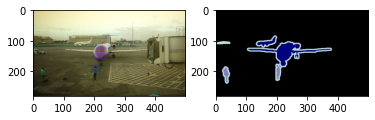

In [4]:
# 이미지 파일 열어보기
encoded_img = np.fromstring(dataset['image'][0]['bytes'], dtype = np.uint8)
img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
print(img[0,0])
plt.subplot(121)
plt.imshow(img)

encoded_img2 = np.fromstring(dataset['mask'][0]['bytes'], dtype = np.uint8)
img2 = cv2.imdecode(encoded_img2, cv2.IMREAD_COLOR)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [5]:
print(len(dataset))
print(len(dataset)*0.8)

train_data = dataset[:2330]
print("train_data[image] 크기: ", len(train_data['image']))
print("train_data[mask] 크기: ",len(train_data['mask']))
print(len(train_data))

test_data = dataset[2330:]
print("test_data[image] 크기: ",len(test_data['image']))
print("test_data[mask] 크기: ",len(test_data['mask']))
print(len(test_data))

2913
2330.4
train_data[image] 크기:  2330
train_data[mask] 크기:  2330
2
test_data[image] 크기:  583
test_data[mask] 크기:  583
2


#### 1.2 데이터 저장 _ train

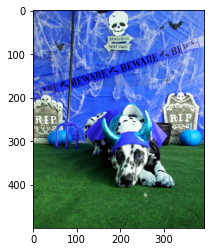

In [6]:
train_image_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/train/image/'
for i in range(len(train_data['image'])):
    encoded_img = np.frombuffer(train_data['image'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(train_image_path + f'{i}.jpg',img_read)

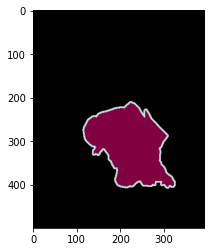

In [7]:
train_mask_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/train/mask/'
for i in range(len(train_data['mask'])):
    encoded_img = np.frombuffer(train_data['mask'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(train_mask_path + f'{i}.jpg',img_read)

#### 1.2 데이터 저장 _ test

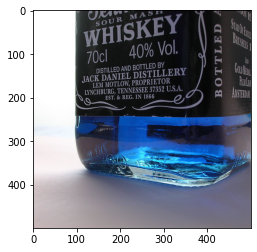

In [8]:
test_image_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/test/image/'
for i in range(len(test_data['image'])):
    encoded_img = np.frombuffer(test_data['image'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(test_image_path + f'{i}.jpg',img_read)

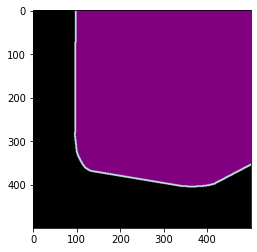

In [9]:
test_mask_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/test/mask/'
for i in range(len(test_data['mask'])):
    encoded_img = np.frombuffer(test_data['mask'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(test_mask_path + f'test_mask{i}.jpg',img_read)

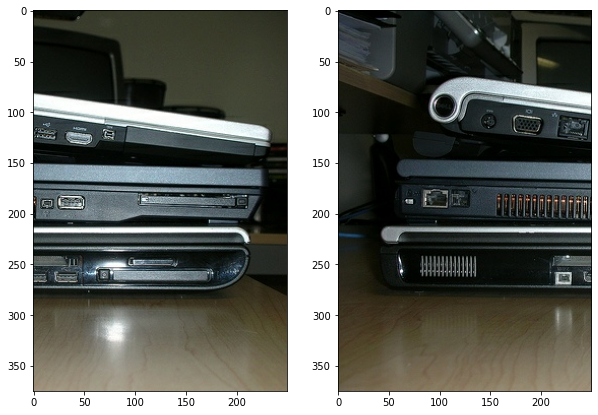

In [13]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f1 = train_image_path + os.listdir(train_image_path)[1]
input_image, real_image = load_img(f1)

# f2 = train_mask_path + os.listdir(train_mask_path)[1]
# input_image, real_image = load_img(f2)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

### 3. Data Augmentation: crop, flip 사용

In [14]:
# 빠른 텐서플로우 연산을 위해 사용
@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

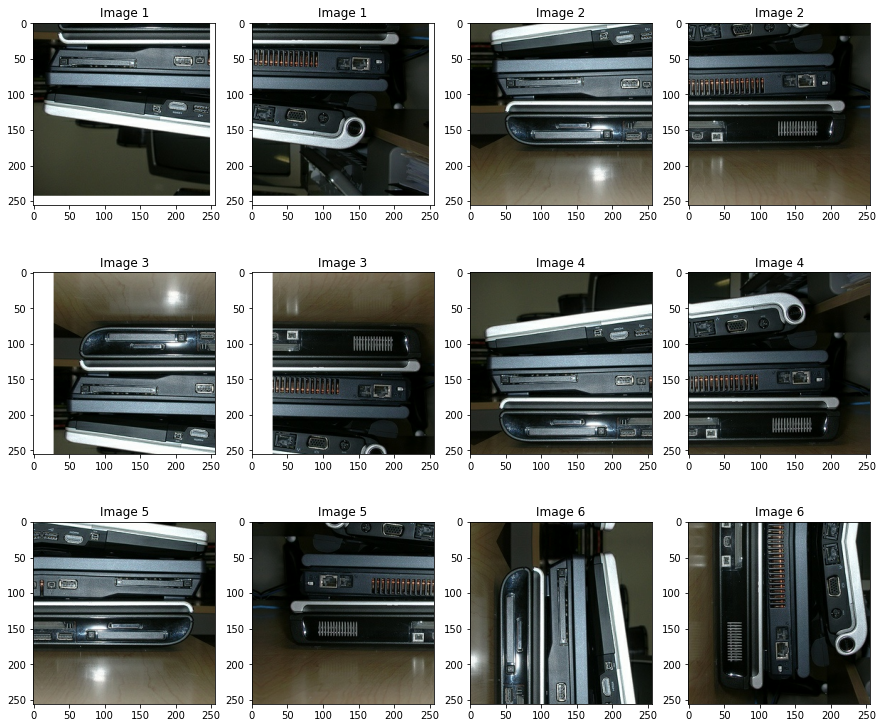

In [15]:
# augmentation 적용 후 시각화 
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [35]:
# 적용된 시각화 확인
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_image_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5
# sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+2)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [500,188,3] vs. shape[1] = [500,187,3]
	 [[{{node StatefulPartitionedCall/concat}}]] [Op:IteratorGetNext]

In [17]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [18]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
  

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [19]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [20]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [21]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [22]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

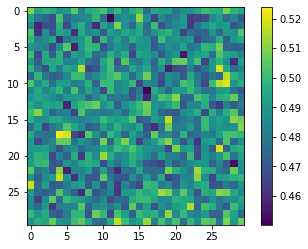

In [23]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [24]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
history = model.fit(img_array, mask_array, batch_size=2, epochs=1, callbacks=[tensorboard_callback])

In [32]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 200회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [500,188,3] vs. shape[1] = [500,187,3]
	 [[{{node StatefulPartitionedCall/concat}}]] [Op:IteratorGetNext]

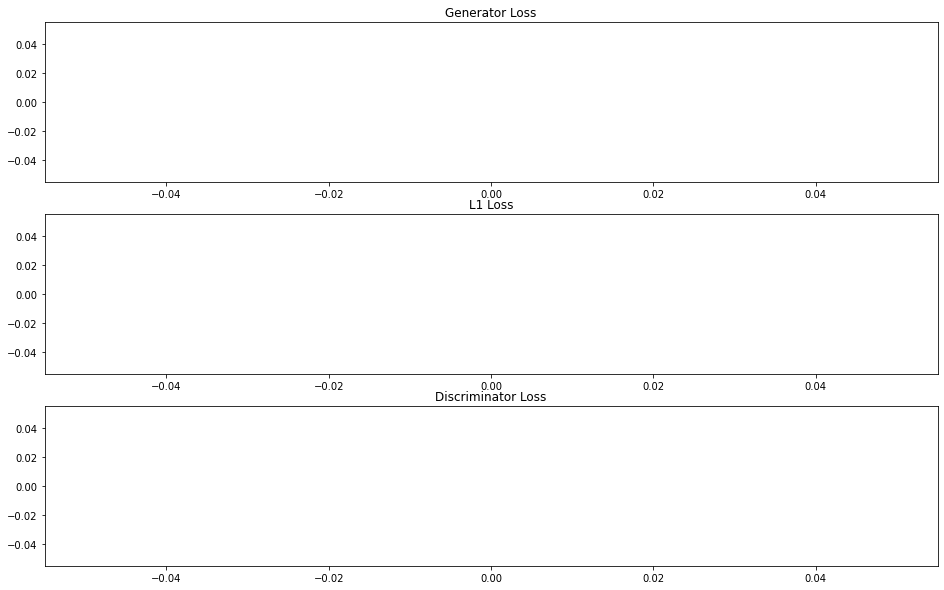

In [36]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

In [ ]:
!tensorboard dev upload --logdir ./loss --name "UNet" --description "Epoch not working" --one_shot --Yes